# Email Analysis
- Look at top senders
- Predict email volume by day: arima, bayesian, holt winters, lstm

In [4]:
#initialize
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#screen width
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 4

# from IPython.core.display import HTML
# HTML("<style>.container{ width: 95% !important; }</style>")

import datetime

# Download headers

In [5]:
# import data.  data is from another script i wrote scraping my email headers
df = pd.read_csv('data/email.csv',parse_dates=['Received'])
df['Received'] = pd.to_datetime([datetime.datetime.strftime(r.Received,'%Y-%m-%d') for r in df.itertuples()])
df.set_index('Received',inplace=True)
df.head(2)

,NumEmails,Sender
Received,,
2017-05-19,1,"""Nextdoor Cool Springs East"" <no-reply@rs.emai..."
2017-05-19,1,"""Nextdoor Cool Springs East"" <reply@rs.email.n..."


# Analyze by day, month, dow

In [3]:
# import warnings
# warnings.filterwarnings("ignore")

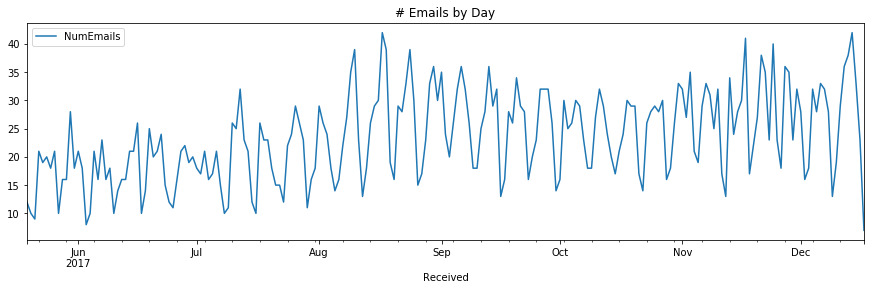

In [6]:
byDay = df.resample('D')['NumEmails'].sum().to_frame()
byDay.plot(title='# Emails by Day');

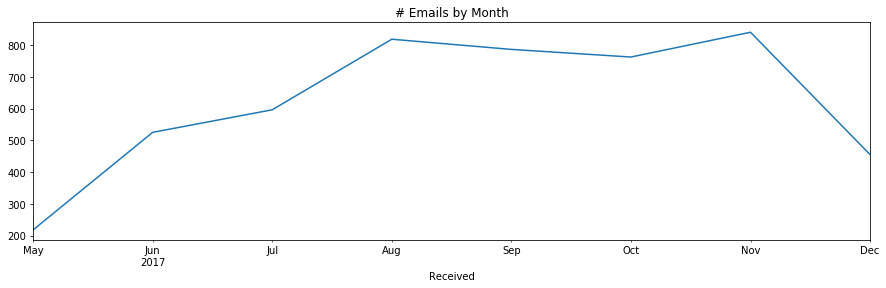

In [17]:
_=df.resample('M')['NumEmails'].sum().plot(title='# Emails by Month')

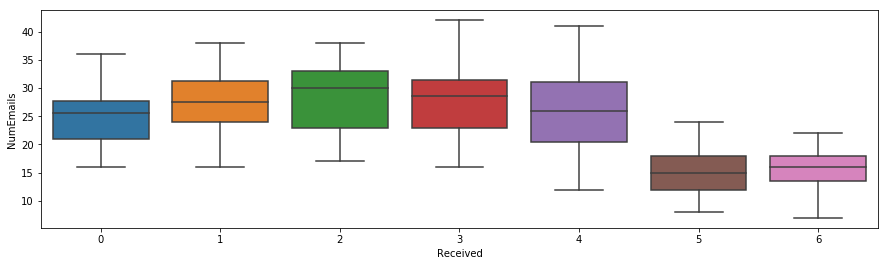

In [18]:
import seaborn as sns
sns.boxplot(byDay.index.weekday,byDay.NumEmails);

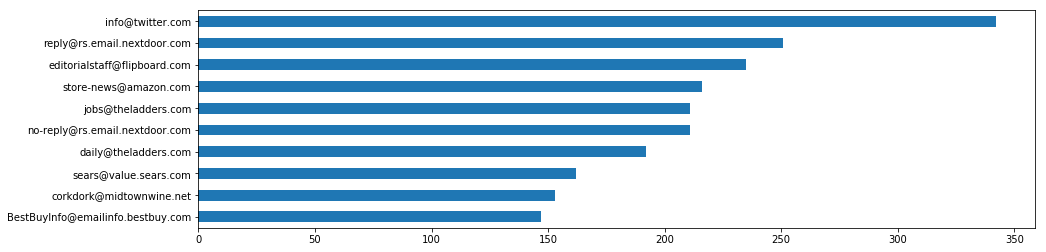

In [19]:
#who's sending me too many emails?

#parse sendername between <>
df['SenderName'] = df.Sender.apply(lambda s: s[s.find('<') + 1 : s.find('>')])
df['SenderName'].value_counts()[:10].plot(kind='barh').invert_yaxis();

# Test Train

In [165]:
cutoff = int(byDay.size * .85) 
train = byDay[:cutoff].values
test = byDay[cutoff:].values

In [201]:
#arima

# lag of 0, by definition, is perfectly correlated (@ 1) to its own values
# look for max lag value > 0 that statistically significant (above dotted threshold) 
# that will give us parameter p

# from pandas.plotting import autocorrelation_plot
# plt.figure(figsize=(15,4))
# autocorrelation_plot(byDay);

# from statsmodels.tsa.stattools import adfuller

## consider box cox?

from pmdarima.arima import auto_arima
m = auto_arima(train,seasonal=True, m=12, error_action='ignore')#, trace=1)
arima = m.predict(n_periods=test.shape[0])
m.get_params()

/home/nathan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/home/nathan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/home/nathan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for m

{'callback': None,
 'disp': 0,
 'maxiter': None,
 'method': None,
 'order': (0, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 0, 2, 12),
 'solver': 'lbfgs',
 'start_params': None,
 'suppress_warnings': False,
 'transparams': True,
 'trend': None,
 'with_intercept': True}

In [186]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# m = SimpleExpSmoothing(train).fit(smoothing_level=0.2,optimized=False)
# es = m.forecast(test.size)
# rmse(test,es)
m = ExponentialSmoothing(train, seasonal_periods=7
#                          , trend='add', seasonal='mul'
                        ).fit(use_boxcox=True)
es = m.forecast(test.size)
rmse(test,es)

8.971949767556895

/home/nathan/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nathan/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


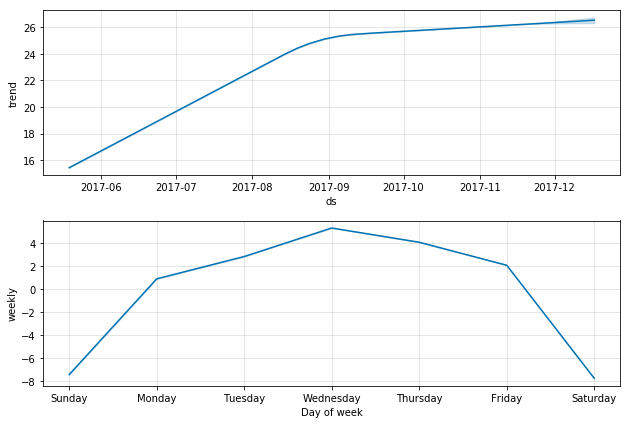

In [67]:
#facebook (bayesian inference)
from fbprophet import Prophet
m = Prophet()
m.fit(byDay[:cutoff].reset_index().rename(columns={'Received':'ds','NumEmails':'y'}))
future = m.make_future_dataframe(periods=test.size)
forecast = m.predict(future)
# fig1 = m.plot(forecast);
fig1 = m.plot_components(forecast)
fb = forecast.tail(test.size)['yhat'].values

In [161]:
## add lstm keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

series = byDay['NumEmails']
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(series.values.reshape(-1,1))
series = pd.DataFrame(scaled)

window_size = 8
series_s = series.copy()
for i in range(window_size):
    series = pd.concat([series, series_s.shift(-(i+1))], axis = 1)
    
series.dropna(axis=0, inplace=True)
series.shape

#split
train_X = series.values[:cutoff,:-1]
test_X = series.values[cutoff:,:-1]
train_X.shape

#reshape to 3d as req'd by lstm
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

train_y = series.values[:cutoff,-1]
test_y = series.values[cutoff:,-1]

# Define the LSTM model
model = Sequential()
model.add(LSTM(input_shape = (window_size,1), units= window_size, return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
model.summary()

model.fit(train_X,train_y,epochs=5,validation_split=0.1)
# ,batch_size=512)

preds = model.predict(test_X)
preds = scaler.inverse_transform(preds)
actuals = scaler.inverse_transform(test_y.reshape(-1,1))
mean_squared_error(actuals,preds)

/home/nathan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(205, 9)

(181, 8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 8, 8)              320       
_________________________________________________________________
dropout_36 (Dropout)         (None, 8, 8)              0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 256)               271360    
_________________________________________________________________
dropout_37 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 257       
_________________________________________________________________
activation_19 (Activation)   (None, 1)                 0         
Total params: 271,937
Trainable params: 271,937
Non-trainable params: 0
_________________________________________________________________
Trai

67.3528258987053

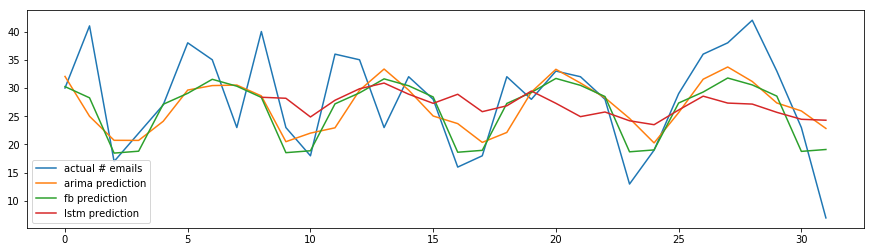

In [189]:
fig, ax = plt.subplots()
ax.plot(test,label='actual # emails');
ax.plot(arima,label='arima prediction');
ax.plot(fb,label='fb prediction');
# ax.plot(es,label='es prediction');
ax.plot(np.append(np.full(window_size, np.nan),preds),label='lstm prediction');

ax.legend();

In [163]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

from sklearn.metrics import mean_absolute_error

print('rmse:')
'arima {:.2f}'.format(rmse(test,arima))
'fb {:.2f}'.format(rmse(test,fb))
'lstm {:.2f}'.format(rmse(test[test.size-preds.size:],preds))

print('mae:')
'arima = {:.2f}'.format(mean_absolute_error(test,arima))
'fb = {:.2f}'.format(mean_absolute_error(test,fb))
'lstm = {:.2f}'.format(mean_absolute_error(test[test.size-preds.size:],preds))



rmse:


'arima 9.71'

'fb 10.19'

'lstm 8.21'

mae:


'arima = 5.68'

'fb = 4.54'

'lstm = 7.03'